In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [8]:
# Define the base directory
base_dir = '/kaggle/input/malaria/Malaria_dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['Uninfected', 'Parasitized']


In [9]:
# Initialize a dictionary to hold counts for each class
class_counts = {'Uninfected': 0, 'Parasitized': 0}

# Loop through each class folder and count the files
for class_name in class_counts.keys():
    class_dir = os.path.join(base_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))  # Count files in the directory

# Display the counts
print("Sample counts for each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")



Sample counts for each class:
Uninfected: 13779 samples
Parasitized: 13779 samples


In [10]:
# Calculate the total number of samples
total_samples = sum(class_counts.values())

# Calculate and display the ratio for each class
print("\nClass distribution ratios:")
for class_name, count in class_counts.items():
    ratio = count / total_samples
    print(f"{class_name}: {ratio:.2%}")



Class distribution ratios:
Uninfected: 50.00%
Parasitized: 50.00%


Displaying random Parasitized images:


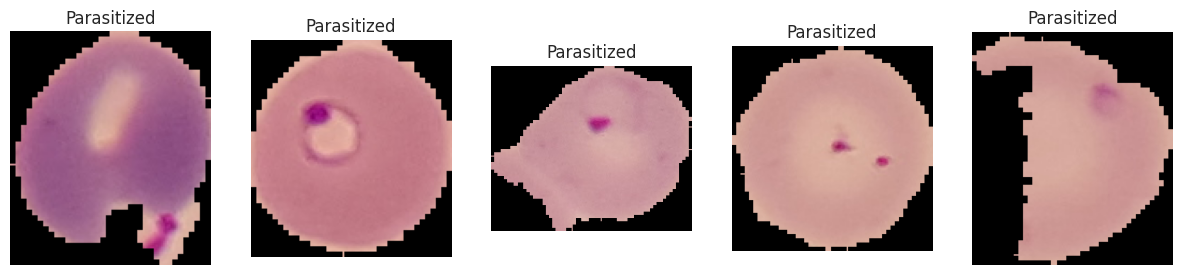

Displaying random Uninfected images:


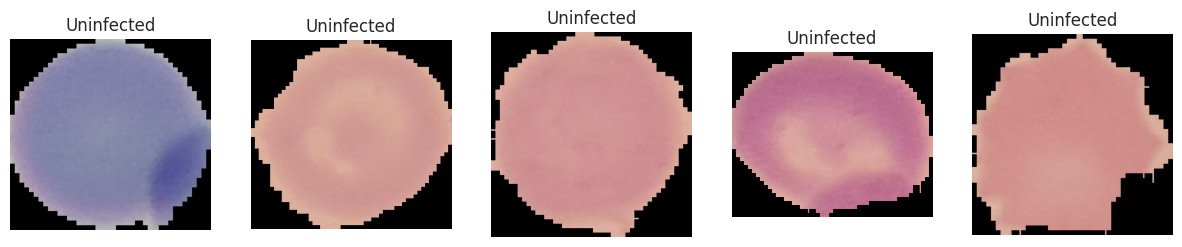

In [11]:
parasitized_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

def show_random_images(directory, title, num_images=5):
    # List all image files in the directory
    image_files = os.listdir(directory)
    sampled_files = random.sample(image_files, num_images)
    
    # Display the images
    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sampled_files):
        file_path = os.path.join(directory, file_name)
        image = Image.open(file_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Show 5 random images from each class
print("Displaying random Parasitized images:")
show_random_images(parasitized_dir, "Parasitized")

print("Displaying random Uninfected images:")
show_random_images(uninfected_dir, "Uninfected")


In [12]:
class Malaria_Dataset(Dataset): 
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
#         print(f"Loading image from: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Print the size of the image to check channels
#         print(f"Image size: {image.size}, Image mode: {image.mode}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [13]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])
# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
# Define class names
classes = ['Uninfected', 'Parasitized']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}

In [15]:
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to labels
for cls in classes:
    images_dir = os.path.join(base_dir, cls) 
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)  
        all_mapped_data.append((img_path, label_mapping[cls]))  

# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")


Mapped DataFrame:


image_path  label
0  /kaggle/input/malaria/Malaria_dataset/Uninfect...      0
1  /kaggle/input/malaria/Malaria_dataset/Uninfect...      0
2  /kaggle/input/malaria/Malaria_dataset/Uninfect...      0
3  /kaggle/input/malaria/Malaria_dataset/Uninfect...      0
4  /kaggle/input/malaria/Malaria_dataset/Uninfect...      0

Total images mapped: 27558


Image counts per class:
Uninfected: 13779 images
Parasitized: 13779 images
Mapped counts per class:
Uninfected: 13779 images (Mapped)
Parasitized: 13779 images (Mapped)
No duplicate entries found.
All labels are valid.


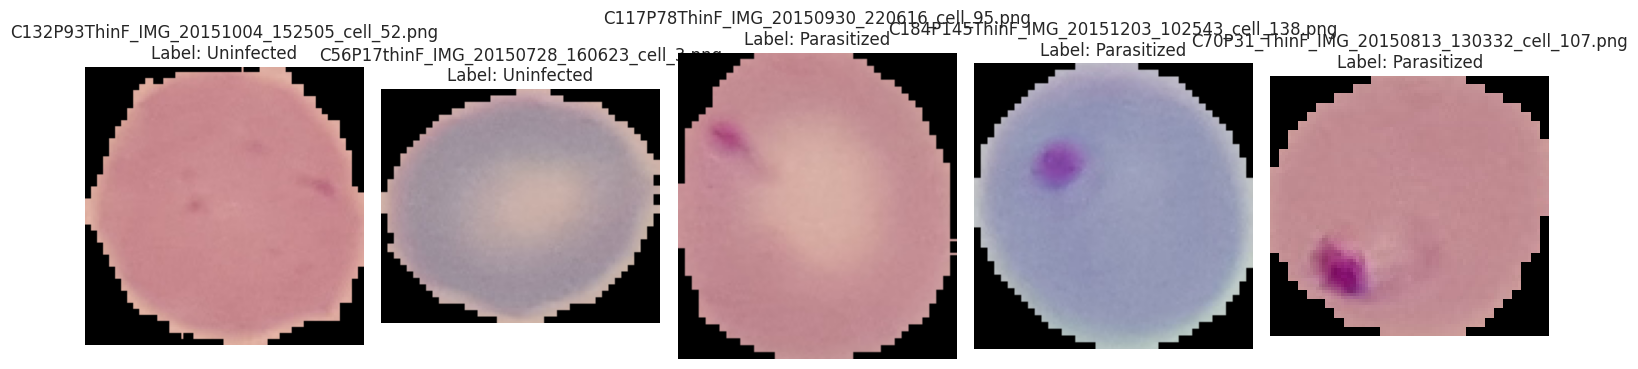

In [16]:
# 1. Verify Count of Images
image_counts = {cls: len(os.listdir(os.path.join(base_dir, cls))) for cls in classes}
print("Image counts per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")

# Compare counts with DataFrame
mapped_count = mapped_df['label'].value_counts().to_dict()
print("Mapped counts per class:")
for cls, count in mapped_count.items():
    print(f"{classes[cls]}: {count} images (Mapped)")

# 2. Check for Duplicates
duplicates = mapped_df[mapped_df.duplicated(subset=['image_path'], keep=False)]
if not duplicates.empty:
    print(f"Found {duplicates.shape[0]} duplicate entries.")
else:
    print("No duplicate entries found.")

# 3. Validate Labels
incorrect_labels = mapped_df[~mapped_df['label'].isin([0, 1])]
if not incorrect_labels.empty:
    print(f"Found {incorrect_labels.shape[0]} entries with incorrect labels.")
else:
    print("All labels are valid.")

# 4. Display Sample Images for Visual Inspection
def display_sample_images(df, num_samples=5):
    plt.figure(figsize=(15, 6))
    
    sample_images = df.sample(num_samples, random_state=42)  # Randomly sample images
    for i, (idx, row) in enumerate(sample_images.iterrows()):
        img_path = row['image_path']
        img_name = os.path.basename(img_path)  # Get just the file name
        label = classes[row['label']]  # Get the label name
        
        # Open the image
        img = Image.open(img_path)
        
        plt.subplot(1, num_samples, i + 1)  # Adjust subplot for 1 row
        plt.imshow(img)
        plt.title(f"{img_name}\nLabel: {label}")  # Show image name and label
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Display a few sample images along with their names and labels
display_sample_images(mapped_df, num_samples=5)

In [17]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")


Total samples: 27558
Training samples: 19290
Validation samples: 2755
Testing samples: 5513


In [18]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")


Training samples: 19290
Validation samples: 2755
Testing samples: 5513


In [19]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[1] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1., 1.])


In [20]:
# Create Dataset instances
train_dataset = Malaria_Dataset(train_data, transform=train_transform)
val_dataset = Malaria_Dataset(val_data, transform=val_test_transform)
test_dataset = Malaria_Dataset(test_data, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 32
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 603, Val: 87, Test: 173


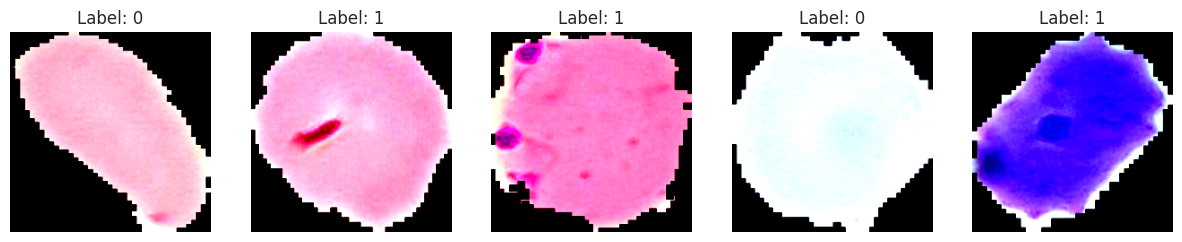

In [21]:
import matplotlib.pyplot as plt

def visualize_batch(images, labels):
    num_images = min(len(images), 5)  # Display up to 5 images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()

# Visualize the first batch from test_loader
images, labels = next(iter(test_loader))
visualize_batch(images, labels)


Training images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


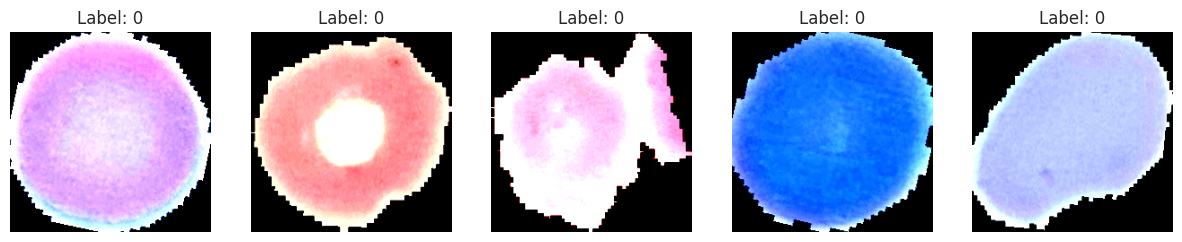

Validation images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


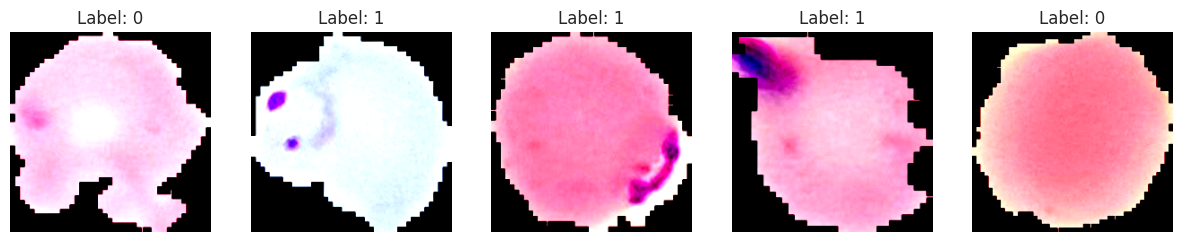

Testing images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


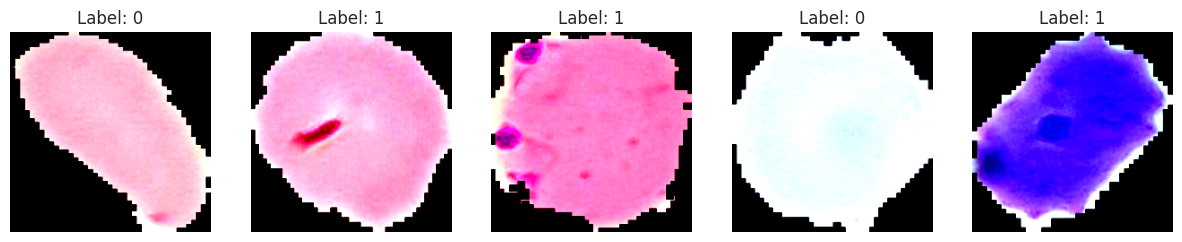

In [22]:
import matplotlib.pyplot as plt

def display_images_from_loader(loader, num_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Ensure num_images does not exceed batch size
    num_images = min(num_images, images.size(0))  # Adjust if batch size is smaller

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
        print(f"Image {i+1} shape: {images[i].shape}")  # Print image shape to verify resize

    plt.show()

# Check train_loader
print("Training images:")
display_images_from_loader(train_loader)

# Check val_loader
print("Validation images:")
display_images_from_loader(val_loader)

# Check test_loader
print("Testing images:")
display_images_from_loader(test_loader)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [24]:
# DIANet Attention Block
class DIABlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(DIABlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Shared MLP for attention
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(x).view(batch, channels)
        avg_attention = self.fc(avg_pool).view(batch, channels, 1, 1)
        
        # Global Max Pooling
        max_pool = self.global_max_pool(x).view(batch, channels)
        max_attention = self.fc(max_pool).view(batch, channels, 1, 1)
        
        # Combine both attentions
        combined_attention = avg_attention + max_attention
        return x * combined_attention  # Apply attention weights

In [25]:
class GhostNet_DIAnet(nn.Module):
    def __init__(self, num_classes):
        super(GhostNet_DIAnet, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part

        # Add DIABlock after feature extraction
        self.dia_block = DIABlock(in_channels=960, reduction=16)  # 960 is the output channel size of GhostNet's features

        # Global average pooling and classifier
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier

    def forward(self, x):
        # Feature extraction
        features = self.features(x)

        # Apply DIABlock for attention
        attention_features = self.dia_block(features)

        # Global average pooling
        pooled_features = self.pool(attention_features)

        # Flatten and classify
        output = torch.flatten(pooled_features, 1)
        output = self.fc(output)

        return output

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2 
model = GhostNet_DIAnet(num_classes=num_classes) 

model.to(device)


print(model)

GhostNet_DIAnet(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (pri

In [27]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:23<00:00,  7.21it/s]


Train Loss: 0.5785, Accuracy: 0.6896


Val Phase: 100%|██████████| 87/87 [00:06<00:00, 13.38it/s]


Val Loss: 0.4245, Accuracy: 0.8131
End of Epoch 1: Train Loss - 0.5785, Val Loss - 0.4245

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.80it/s]


Train Loss: 0.2813, Accuracy: 0.8820


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 17.71it/s]


Val Loss: 0.1492, Accuracy: 0.9495
End of Epoch 2: Train Loss - 0.2813, Val Loss - 0.1492

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.71it/s]


Train Loss: 0.1647, Accuracy: 0.9454


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 18.39it/s]


Val Loss: 0.1424, Accuracy: 0.9564
End of Epoch 3: Train Loss - 0.1647, Val Loss - 0.1424

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.67it/s]


Train Loss: 0.1464, Accuracy: 0.9506


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 16.70it/s]


Val Loss: 0.1260, Accuracy: 0.9586
End of Epoch 4: Train Loss - 0.1464, Val Loss - 0.1260

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.78it/s]


Train Loss: 0.1367, Accuracy: 0.9551


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 17.40it/s]


Val Loss: 0.1185, Accuracy: 0.9604
End of Epoch 5: Train Loss - 0.1367, Val Loss - 0.1185

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:16<00:00,  7.85it/s]


Train Loss: 0.1310, Accuracy: 0.9550


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 15.76it/s]


Val Loss: 0.1167, Accuracy: 0.9612
End of Epoch 6: Train Loss - 0.1310, Val Loss - 0.1167

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:16<00:00,  7.86it/s]


Train Loss: 0.1273, Accuracy: 0.9569


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 18.47it/s]


Val Loss: 0.1142, Accuracy: 0.9608
End of Epoch 7: Train Loss - 0.1273, Val Loss - 0.1142

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:19<00:00,  7.61it/s]


Train Loss: 0.1223, Accuracy: 0.9588


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 17.11it/s]


Val Loss: 0.1090, Accuracy: 0.9590
End of Epoch 8: Train Loss - 0.1223, Val Loss - 0.1090

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:16<00:00,  7.84it/s]


Train Loss: 0.1197, Accuracy: 0.9584


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 16.68it/s]


Val Loss: 0.1090, Accuracy: 0.9601
End of Epoch 9: Train Loss - 0.1197, Val Loss - 0.1090

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.73it/s]


Train Loss: 0.1148, Accuracy: 0.9605


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 17.48it/s]


Val Loss: 0.1096, Accuracy: 0.9615
End of Epoch 10: Train Loss - 0.1148, Val Loss - 0.1096

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.75it/s]


Train Loss: 0.1062, Accuracy: 0.9634


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 16.03it/s]


Val Loss: 0.1033, Accuracy: 0.9626
End of Epoch 11: Train Loss - 0.1062, Val Loss - 0.1033

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:15<00:00,  7.95it/s]


Train Loss: 0.1064, Accuracy: 0.9625


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 16.88it/s]


Val Loss: 0.1015, Accuracy: 0.9644
End of Epoch 12: Train Loss - 0.1064, Val Loss - 0.1015

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.79it/s]


Train Loss: 0.1035, Accuracy: 0.9644


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 15.84it/s]


Val Loss: 0.1031, Accuracy: 0.9637
End of Epoch 13: Train Loss - 0.1035, Val Loss - 0.1031

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.76it/s]


Train Loss: 0.1010, Accuracy: 0.9639


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 17.98it/s]


Val Loss: 0.1018, Accuracy: 0.9648
End of Epoch 14: Train Loss - 0.1010, Val Loss - 0.1018

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.69it/s]


Train Loss: 0.1012, Accuracy: 0.9638


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 18.11it/s]


Val Loss: 0.1028, Accuracy: 0.9648
End of Epoch 15: Train Loss - 0.1012, Val Loss - 0.1028

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:15<00:00,  7.97it/s]


Train Loss: 0.1030, Accuracy: 0.9641


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 18.20it/s]


Val Loss: 0.1026, Accuracy: 0.9644
End of Epoch 16: Train Loss - 0.1030, Val Loss - 0.1026

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.66it/s]


Train Loss: 0.1029, Accuracy: 0.9639


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 17.14it/s]


Val Loss: 0.1021, Accuracy: 0.9612
End of Epoch 17: Train Loss - 0.1029, Val Loss - 0.1021

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.70it/s]


Train Loss: 0.0985, Accuracy: 0.9653


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 15.28it/s]


Val Loss: 0.0999, Accuracy: 0.9641
End of Epoch 18: Train Loss - 0.0985, Val Loss - 0.0999

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:19<00:00,  7.62it/s]


Train Loss: 0.0981, Accuracy: 0.9657


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 17.31it/s]


Val Loss: 0.1022, Accuracy: 0.9626
End of Epoch 19: Train Loss - 0.0981, Val Loss - 0.1022

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.67it/s]


Train Loss: 0.0983, Accuracy: 0.9653


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 17.54it/s]


Val Loss: 0.1007, Accuracy: 0.9648
End of Epoch 20: Train Loss - 0.0983, Val Loss - 0.1007

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.82it/s]


Train Loss: 0.0965, Accuracy: 0.9672


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 17.57it/s]


Val Loss: 0.1009, Accuracy: 0.9637
End of Epoch 21: Train Loss - 0.0965, Val Loss - 0.1009

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:18<00:00,  7.63it/s]


Train Loss: 0.0963, Accuracy: 0.9653


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 17.12it/s]


Val Loss: 0.1004, Accuracy: 0.9641
End of Epoch 22: Train Loss - 0.0963, Val Loss - 0.1004

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:16<00:00,  7.86it/s]


Train Loss: 0.0973, Accuracy: 0.9655


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 16.69it/s]


Val Loss: 0.1009, Accuracy: 0.9648
End of Epoch 23: Train Loss - 0.0973, Val Loss - 0.1009

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:16<00:00,  7.85it/s]


Train Loss: 0.0968, Accuracy: 0.9659


Val Phase: 100%|██████████| 87/87 [00:04<00:00, 17.56it/s]


Val Loss: 0.1013, Accuracy: 0.9648
End of Epoch 24: Train Loss - 0.0968, Val Loss - 0.1013

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 603/603 [01:17<00:00,  7.82it/s]


Train Loss: 0.0960, Accuracy: 0.9657


Val Phase: 100%|██████████| 87/87 [00:05<00:00, 16.65it/s]

Val Loss: 0.1011, Accuracy: 0.9648
End of Epoch 25: Train Loss - 0.0960, Val Loss - 0.1011

Training complete. Best Validation Accuracy: 0.9648


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing: 100%|██████████| 173/173 [00:12<00:00, 13.42it/s]


Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.95      0.98      0.96      2757
 Parasitized       0.98      0.95      0.96      2756

    accuracy                           0.96      5513
   macro avg       0.96      0.96      0.96      5513
weighted avg       0.96      0.96      0.96      5513



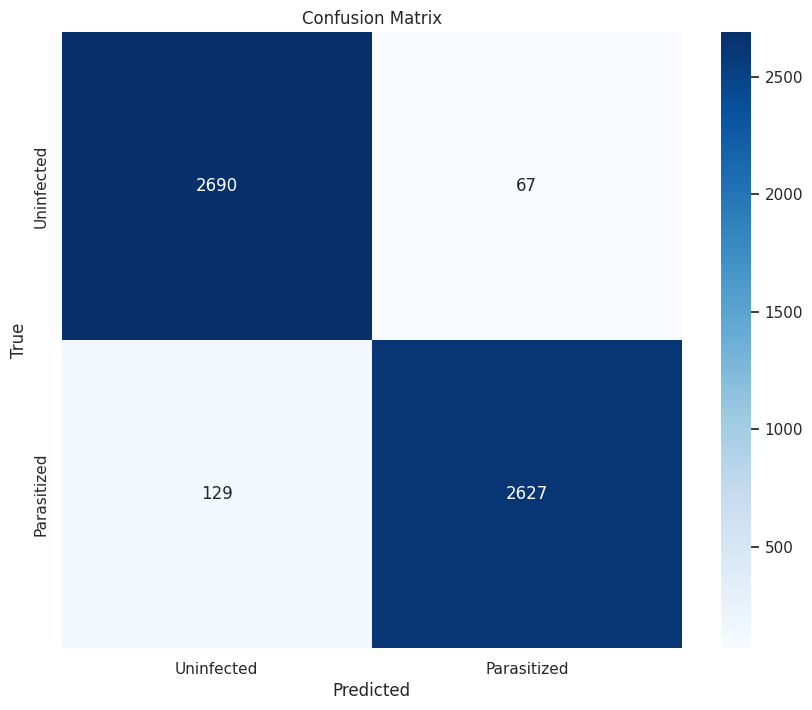

In [30]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

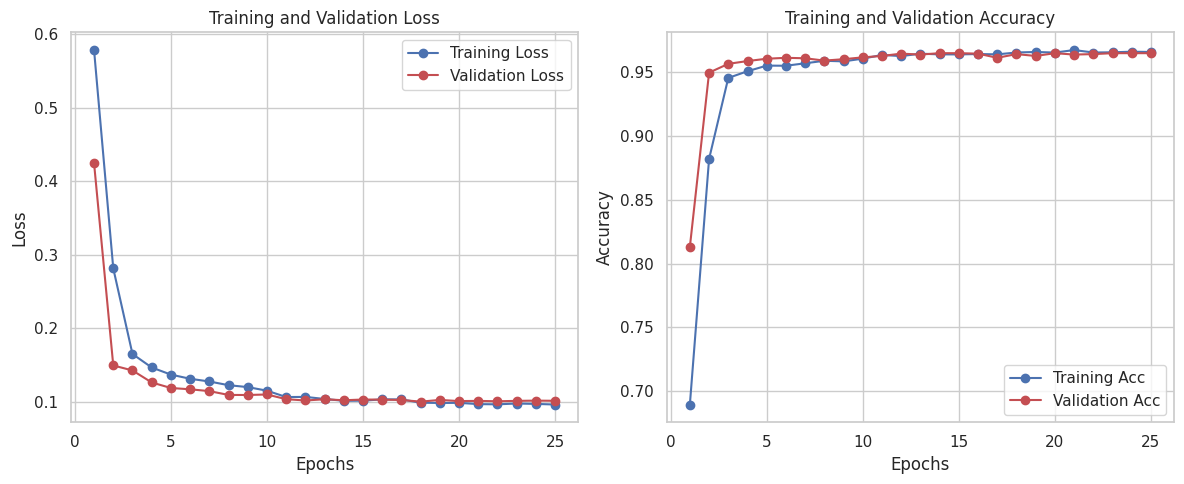

In [31]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

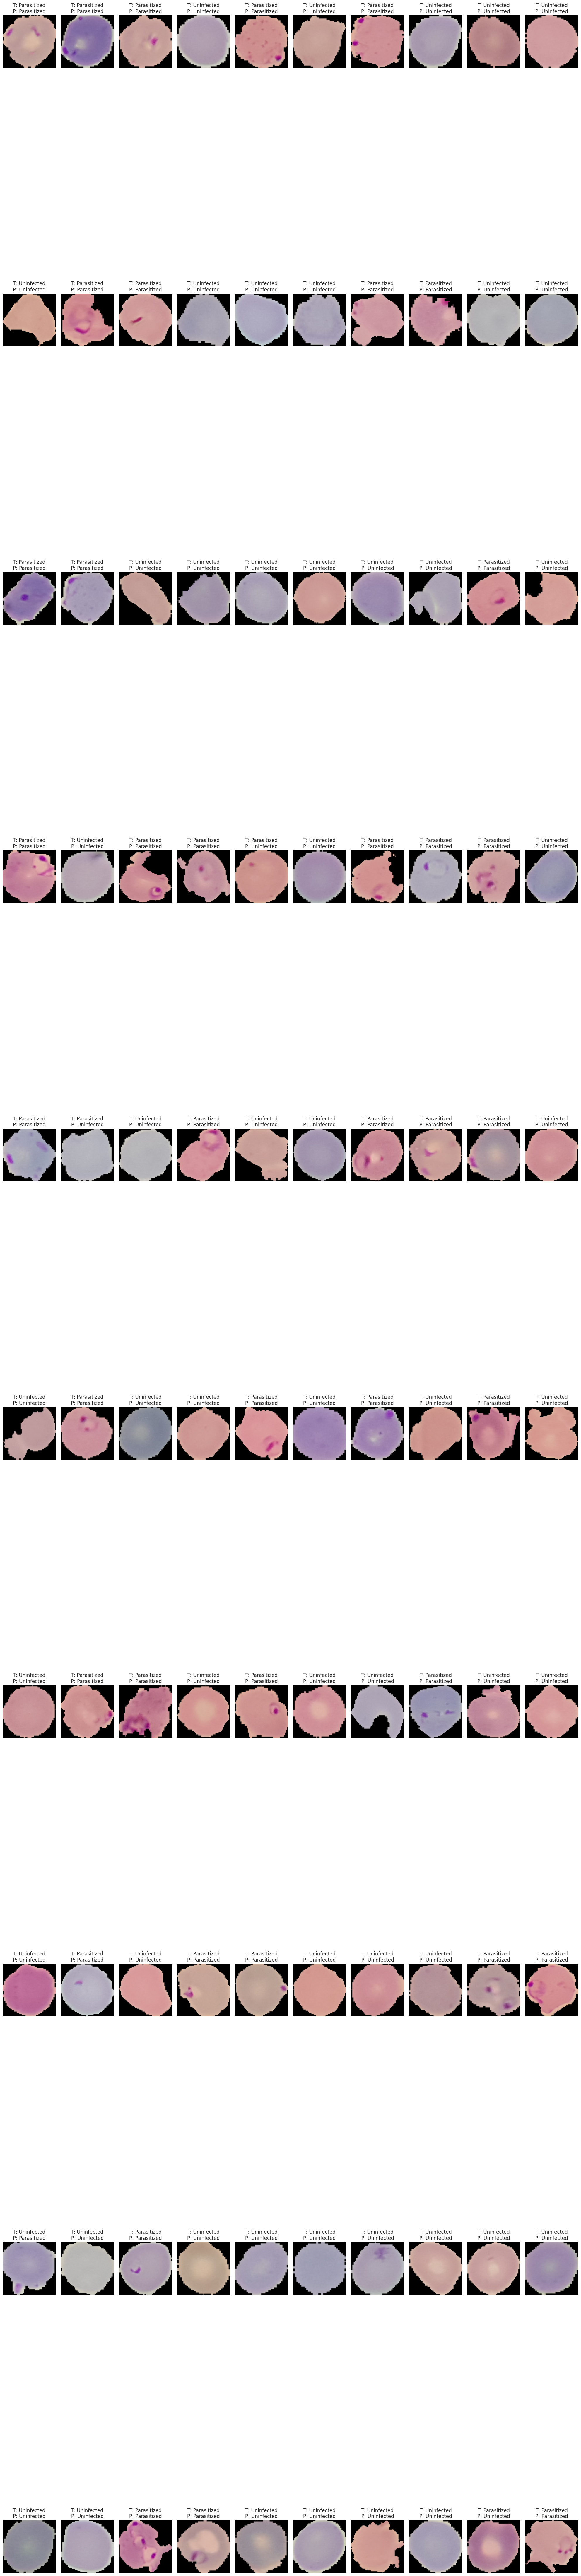

In [32]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
